# Leaf Instance Segmentation Pipeline

# 0. Импортируем библиотеки и загружаем данные

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [3]:
from plantcv import plantcv as pcv

# 1. Inference

## 1.1 Настройка конфига

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))
cfg.DATASETS.TEST = ("potato_test",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "mask_r_cnn.pth")  # путь к твоим весам
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # порог для визуализации

## 1.2 Создание модели

In [6]:
predictor = DefaultPredictor(cfg)

## 1.3 Визуализация Instance Segmentation

In [30]:
image_path = 'images/self.jpg'

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

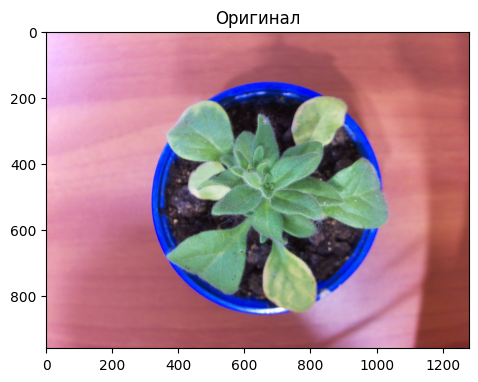

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(image_rgb)

In [10]:
outputs = predictor(image)

C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
v = Visualizer(image_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

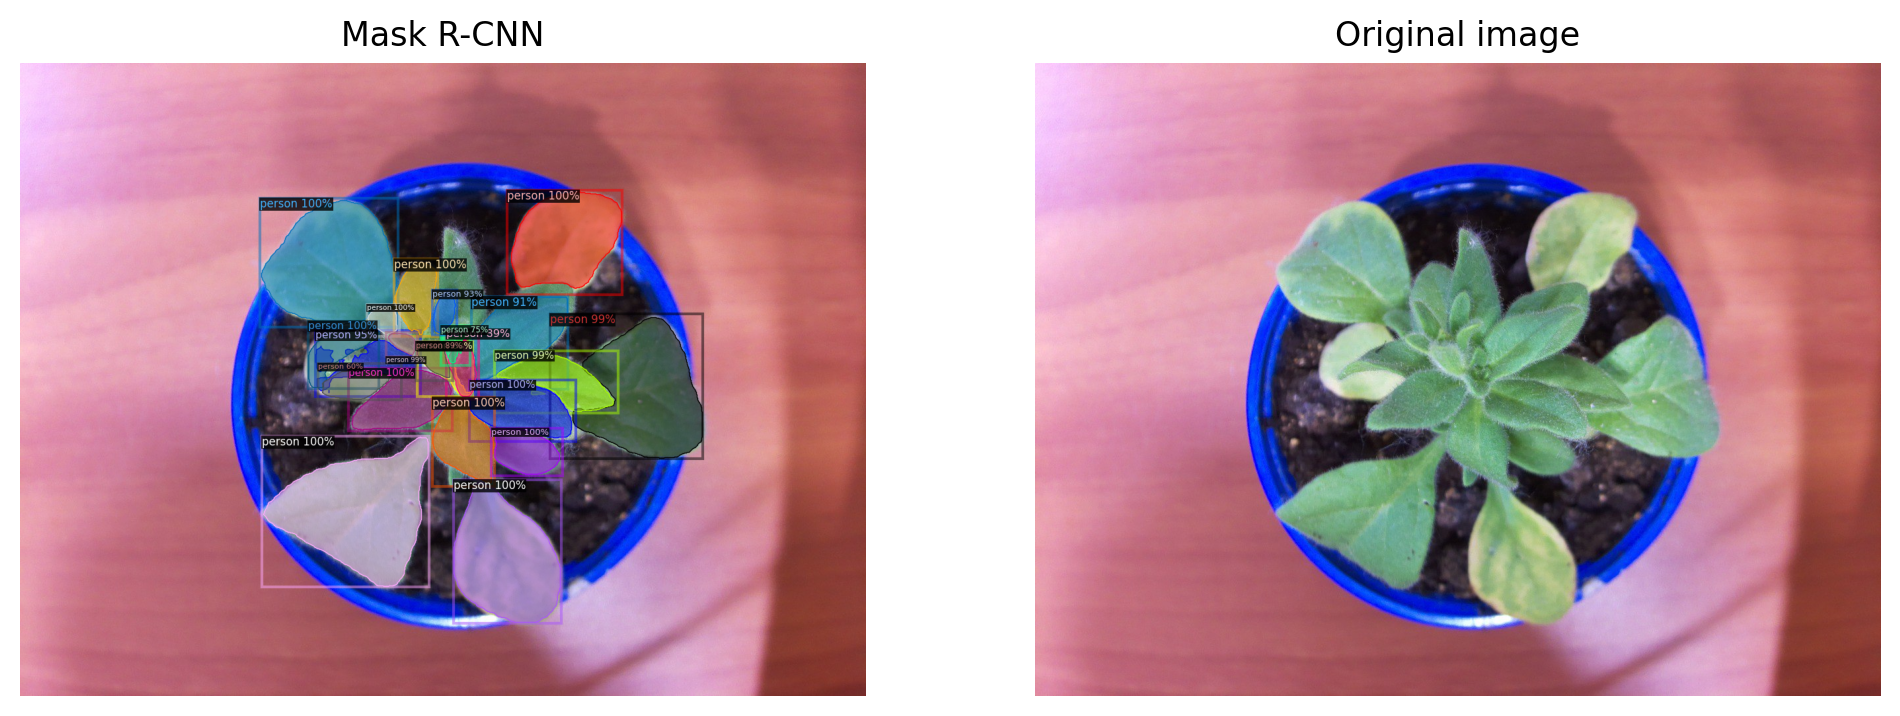

In [12]:
_, ax = plt.subplots(1,2, figsize=(12, 8), dpi=200)

ax[0].imshow(out.get_image())
ax[0].axis("off")
ax[0].set_title('Mask R-CNN')
ax[1].imshow(image_rgb)
ax[1].axis("off")
ax[1].set_title('Original image')
plt.show()

In [13]:
instances = outputs["instances"].to("cpu")

num_masks = len(instances)
print("Количество сегментированных листьев (confidence > 50%):", num_masks)

Количество сегментированных листьев (confidence > 50%): 22


# 2. Удаление фона

In [14]:
# 1. Получаем маски
masks = outputs["instances"].pred_masks.cpu().numpy()

combined_mask = np.any(masks, axis=0).astype(np.uint8)

In [15]:
# 2. Подготовим пустой фон
h, w = combined_mask.shape
background_color = (0, 0, 0)
background = np.full((h,w,3), background_color, dtype=np.uint8)

In [16]:
# Подготовим RGB изображение
image_2 = image_rgb.copy()

# Расширим маску до 3 каналов
mask_3c = np.stack([combined_mask]*3, axis=-1)

# Применим маску
image_wb = image_2 * mask_3c + background * (1 - mask_3c)

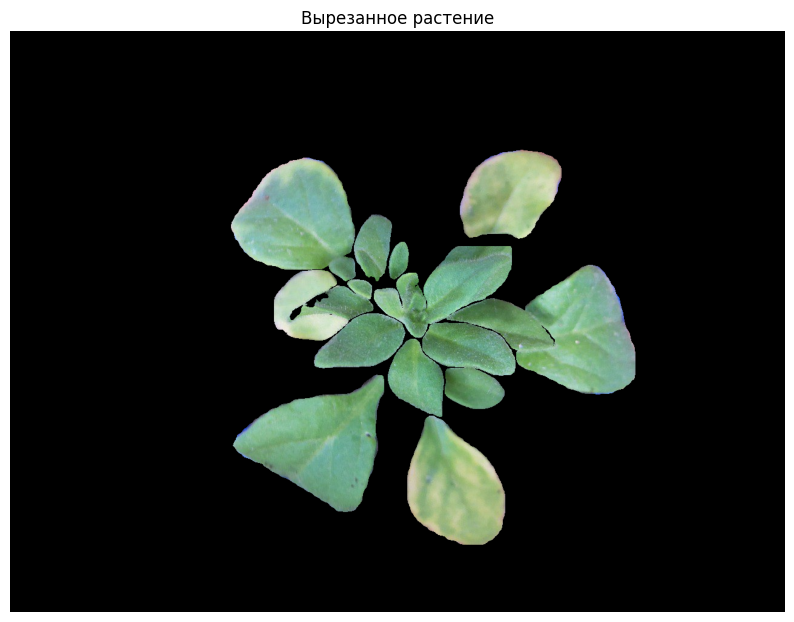

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image_wb)
plt.axis('off')
plt.title("Вырезанное растение")
plt.show()

# 3. Анализа цвета

In [22]:
pcv.params.debug = "plot" 
# Change display settings
pcv.params.dpi = 300
pcv.params.text_size = 5
pcv.params.text_thickness = 5

In [23]:
hist_figure1 = pcv.visualize.histogram(image_wb, bins=25)

alt.Chart(...)